In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

2022-05-12 11:36:39.465444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 11:36:39.465483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
keras = tf.keras
# wget the file from https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
with open("Data/shakespeare.txt") as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
print("Loaded a corpus of {0} characters".format(corpus_length))

Loaded a corpus of 1115394 characters


In [3]:
# Get a unique identifier for each char in the corpus, 
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 65 unique characters.


In [4]:
print(encoding)
print(decoding)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i',

## Many to one approach

In [5]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 20
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 1115374 sentences of length 20


In [6]:
print('Encoded data[0]  : {}'.format(X_data[0]))
print('Decoded data[0]  : {}'.format([decoding[idx] for idx in X_data[0]]))
print('Target of data[0]: {}'.format(decoding[y_data[0]]))

Encoded data[0]  : [18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56]
Decoded data[0]  : ['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r']
Target of data[0]: e


In [7]:
# Vectorize our data and labels. We want everything in one-hot.
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=bool)
y = np.zeros((num_sentences, num_chars), dtype=bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}"
      .format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}"
      .format(X.shape, sentence_length))

Sanity check y. Dimension: (1115374, 65) # Sentences: 1115374 Characters in corpus: 65
Sanity check X. Dimension: (1115374, 20, 65) Sentence length: 20


In [8]:
# Define our model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(256, input_shape=(sentence_length, num_chars), 
                    return_sequences=False))
model.add(keras.layers.Dense(num_chars))
model.add(keras.layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               82432     
                                                                 
 dense (Dense)               (None, 65)                16705     
                                                                 
 activation (Activation)     (None, 65)                0         
                                                                 
Total params: 99,137
Trainable params: 99,137
Non-trainable params: 0
_________________________________________________________________


2022-05-12 11:36:56.374567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-12 11:36:56.374613: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-12 11:36:56.374635: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f05db13702d5): /proc/driver/nvidia/version does not exist
2022-05-12 11:36:56.376807: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
8714/8714 [==============================] - 151s 17ms/step - loss: 2.0726 - accuracy: 0.4042
Epoch 2/10
8714/8714 [==============================] - 149s 17ms/step - loss: 1.7616 - accuracy: 0.4806
Epoch 3/10
8714/8714 [==============================] - 147s 17ms/step - loss: 1.6617 - accuracy: 0.5067
Epoch 4/10
8714/8714 [==============================] - 155s 18ms/step - loss: 1.6080 - accuracy: 0.5199
Epoch 5/10
8714/8714 [==============================] - 145s 17ms/step - loss: 1.5744 - accuracy: 0.5284
Epoch 6/10
8714/8714 [==============================] - 165s 19ms/step - loss: 1.5503 - accuracy: 0.5343
Epoch 7/10
8714/8714 [==============================] - 156s 18ms/step - loss: 1.5336 - accuracy: 0.5384
Epoch 8/10
8714/8714 [==============================] - 146s 17ms/step - loss: 1.5202 - accuracy: 0.5417
Epoch 9/10
8714/8714 [==============================] - 144s 17ms/step - loss: 1.5103 - accuracy: 0.5440
Epoch 10/10
8714/8714 [==============================] 

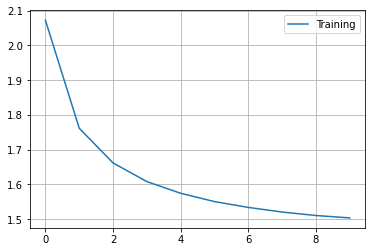

In [9]:
#training time
log = model.fit(X, y, epochs=10, batch_size=128)
plt.plot(log.history['loss'], label='Training')
plt.legend()
plt.grid()

In [10]:

def make_seed(seed_phrase=""):
        if seed_phrase:  # make sure the seed has the right length
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            # sample randomly the seed from corpus
            seed = random.randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]
        return pattern

seed_pattern = make_seed("Once upon a time in ")
print("seed = " + seed_pattern)

X = np.zeros((1, sentence_length, num_chars), dtype=float)
for i, character in enumerate(seed_pattern):
    X[0, i, encoding[character]] = 1

generated_text = ""
for i in range(500):
    output_prob = model.predict(X, verbose=0)[0]
    # in previous line predict() gives a tensor of shape (1, 65) 
    # with 1 being the size of the batch, for that we use [0] to get a vector
    prediction = np.random.choice(num_chars, p = output_prob )
    generated_text += decoding[prediction]
    activations = np.zeros((1, 1, num_chars), dtype=bool)
    activations[0, 0, prediction] = 1
    #now remove first char and glue the predicted one
    X = np.concatenate((X[:, 1:, :], activations), axis=1)
print(generated_text)

seed = Once upon a time in 
dingerol may the devare.

OLFOY
TRANIO:
Come, the Lextless that unlittle behands to the friends, a didget of me then. Belightous
Within both please their noble.

CUMOFITARTAs:
You have have play Byough within to be so, toom, for my lordshy fear constlenomers.

SICINIUS:
No lord, well, saw,--

Clown:
After wear provised,
That was
affections
ere, sirs with ithe,
To-nought thou now that
mindnam, great fone queen offery sin;
I' the priet strive
Which better give his head
And seed is qoither. O, in p


## Many to many approach

In [11]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 20
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i+1:i+1 + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append([encoding[char] for char in next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 1115374 sentences of length 20


In [12]:
print(X_data[0])

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56]


In [13]:
print([decoding[idx] for idx in X_data[0]])
print([decoding[idx] for idx in y_data[0]])

['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r']
['i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r', 'e']


In [14]:
# Vectorize our data and labels. We want everything in one-hot.
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=bool)
y = np.zeros((num_sentences, sentence_length, num_chars), dtype=bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
for i, sentence in enumerate(y_data):
    for t, encoded_char in enumerate(sentence):
        y[i, t, encoded_char] = 1

In [15]:
# Define our model
modelmm = keras.models.Sequential()
modelmm.add(keras.layers.SimpleRNN(256, input_shape=(sentence_length, num_chars), 
                    return_sequences=True))
modelmm.add(keras.layers.TimeDistributed(keras.layers.Dense(num_chars,
                                                          activation='softmax')))
modelmm.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
modelmm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 20, 256)           82432     
                                                                 
 time_distributed (TimeDistr  (None, 20, 65)           16705     
 ibuted)                                                         
                                                                 
Total params: 99,137
Trainable params: 99,137
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
8714/8714 [==============================] - 188s 21ms/step - loss: 1.7973 - accuracy: 0.4710
Epoch 2/10
8714/8714 [==============================] - 187s 21ms/step - loss: 1.5610 - accuracy: 0.5280
Epoch 3/10
8714/8714 [==============================] - 188s 22ms/step - loss: 1.5140 - accuracy: 0.5388
Epoch 4/10
8714/8714 [==============================] - 302s 35ms/step - loss: 1.4907 - accuracy: 0.5441
Epoch 5/10
8714/8714 [==============================] - 299s 34ms/step - loss: 1.4764 - accuracy: 0.5474
Epoch 6/10
8714/8714 [==============================] - 447s 51ms/step - loss: 1.4664 - accuracy: 0.5496
Epoch 7/10
8714/8714 [==============================] - 201s 23ms/step - loss: 1.4592 - accuracy: 0.5513
Epoch 8/10
8714/8714 [==============================] - 194s 22ms/step - loss: 1.4535 - accuracy: 0.5525
Epoch 9/10
8714/8714 [==============================] - 191s 22ms/step - loss: 1.4488 - accuracy: 0.5536
Epoch 10/10
8714/8714 [==============================] 

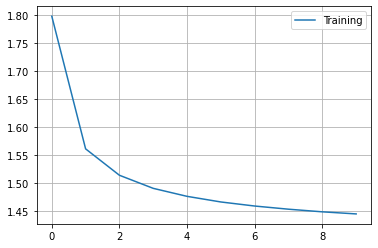

In [16]:
#training time
log = modelmm.fit(X, y, epochs=10, batch_size=128)
plt.plot(log.history['loss'], label='Training')
plt.legend()
plt.grid()

In [18]:
def make_seed(seed_phrase=""):
        if seed_phrase:  # make sure the seed has the right length
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            # sample randomly the seed from corpus
            seed = random.randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]
        return pattern

seed_pattern = make_seed("Romeo said:")

X = np.zeros((1, sentence_length, num_chars), dtype=float)
for i, character in enumerate(seed_pattern):
    X[0, i, encoding[character]] = 1

generated_text = ""
for i in range(500):
    output_prob = modelmm.predict(X, verbose=0)[0][-1]
    # in previous line predict() gives a tensor of shape (1, 20, 65) 
    # with 1 being the size of the batch, for that we use [0][-1] 
    # to remove the batch dim and get the last prediction : a vector of size 65
    prediction = np.random.choice(num_chars, p = output_prob )
    generated_text += decoding[prediction]
    activations = np.zeros((1, 1, num_chars), dtype=bool)
    activations[0, 0, prediction] = 1
    #now remove first char and glue the predicted one
    X = np.concatenate((X[:, 1:, :], activations), axis=1)
print(generated_text)

dly's high.
By his old praises up,
And over indeed I was the humbreh
The words for friend, the enemies!

FERDINAND:
Adie'?

JULIET:
No, silenty wars saft mourn! the queen of thy face, inconstant the sound longet to a sense, thou that be fortune, madam, my treachal; any tendering
I as committed by reprind:
Broke
The accuse,
Thou betwixt found it were Marcius, who mistrades together,
Which drelm it mose prevent to lined white chave rather tears of sworn them, 'Swaywa.
We doubton your son:
We have 
